_Reading this on GitHub? <a href="./">Go to the parent folder</a> for instructions on
how to run this notebook using the Advanced Analytics Workspace!_

# ESTMA Payments by Country and Entity

Let's do some R analysis to gain some insights into the Open ESTMA Data.

In [ ]:
options(warn = -1)

library(dplyr)
library(lubridate)
library(ggplot2)
library(RColorBrewer)

# Nice colours
if (!require("viridis")) { 
  install.packages(
    "viridis",
    repos = "http://cran.us.r-project.org"
    )
}
library(viridis)

# Get the data

Grab the data straight from GitHub.

In [24]:
estma <- read.csv("https://github.com/StatCan/hackathon-ginyu-force-data/raw/main/estma-payments.csv")

Mutate the tables to adjust the column types.

In [25]:
# Normalize 
estma <- estma %>%
  mutate(period_end_date=mdy(period_end_date)) %>%
  mutate(period_start_date=mdy(period_start_date)) %>%
  mutate(amount_reported_cad = as.numeric(amount_reported_cad))

Display a sample record.

In [26]:
estma[1,] %>% str

'data.frame':	1 obs. of  13 variables:
 $ estma_id           : chr "E001568"
 $ entity             : chr "Rochester Resources Ltd."
 $ jurisdiction       : chr "Canada"
 $ period_start_date  : Date, format: NA
 $ period_end_date    : Date, format: NA
 $ country            : chr "Mexico"
 $ payee_project_name : chr "GENERAL MINING DIRECTION OF THE SECRETARIAT OF ECONOMY"
 $ payee_or_project   : chr "payee"
 $ payment_category   : chr "Fees"
 $ amount_reported_cad: num 217444
 $ type_of_report     : chr "Individual Report"
 $ reporting_cycle    : int 2016
 $ web_link           : chr "https://www.dropbox.com/s/qh3p9uj615ryv4u/RCT - 2017.xlsx?dl=0"


## Amount reported by country

In [27]:
by_country <- estma %>%
  group_by(country) %>%
  summarise(Amount = sum(amount_reported_cad))

# Remove bottom 3% of the range
amount_range <- range(by_country$Amount)
cutoff_percentage = 0.03
cutoff <- (1 - cutoff_percentage) * amount_range[1] + (cutoff_percentage) * amount_range[2]

by_country_cutoff <- by_country %>%
  filter(Amount > cutoff) %>%
  arrange(desc(Amount))

cat(
  sprintf("Total countries: %d", length(by_country$country)),
  sprintf("Countries above %.1f%% of range: %d",
          cutoff_percentage * 100,
          length(by_country_cutoff$country)),
  sep="\n"
)

Total countries: 133
Countries above 3.0% of range: 27


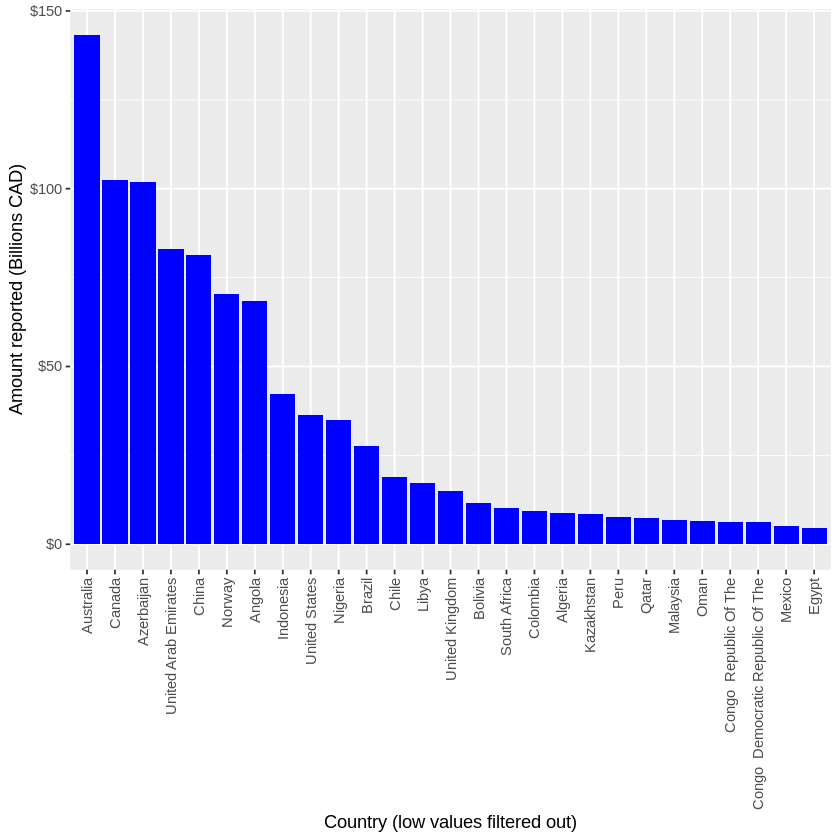

In [28]:
ggplot(data=by_country_cutoff) +
  geom_col(aes(x=reorder(country, -Amount), y=Amount / 1e9), fill="blue") +
  labs(x="Country (low values filtered out)", y="Amount reported (Billions CAD)") +
  theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +
  scale_y_continuous(labels=scales::dollar_format())

## Large entities

In [29]:
by_entity <- estma %>% 
  group_by(entity) %>% 
  summarise(Amount = sum(amount_reported_cad))

cat(sprintf("Number of entities: %d\n", length(by_entity$entity)))

Number of entities: 695


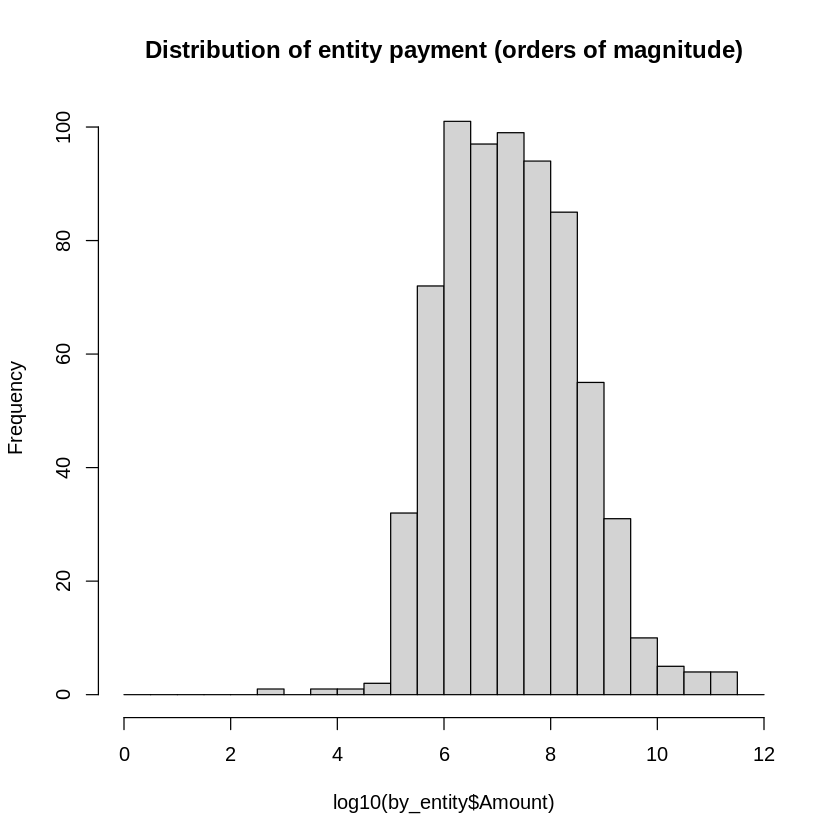

In [30]:
hist(
  main="Distribution of entity payment (orders of magnitude)",
  log10(by_entity$Amount),
  breaks=seq(0, ceiling(max(log10(by_entity$Amount))), by=0.5)
)

How much is contributed to the total amount per quantile?

In [31]:
total = sum(by_entity$Amount)

num_quantiles <- 100
per_quantile <- by_entity %>% 
  mutate(quantile=ntile(by_entity$Amount, num_quantiles)) %>%
  group_by(quantile) %>%
  summarise(Amount=sum(Amount) / total)

### How much does each quantile contribute in terms of total share?

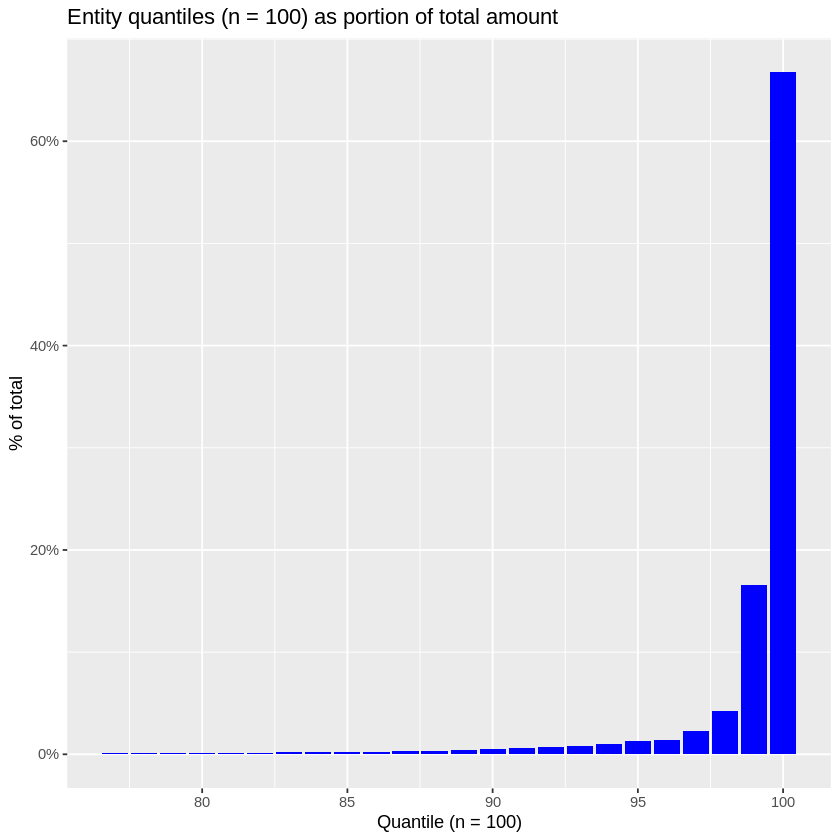

In [32]:
# Map the quantiles to a colour
colours <- viridis_pal(option="D")(num_quantiles)
colours <- sample(colours) # shuffle
quantile_colours = list()
for (i in 1:num_quantiles) {
  quantile_colours[[i]] = colours[[i]]
}

ggplot(data=per_quantile %>% filter(Amount > 0.001)) +
  geom_col(aes(x=quantile, y=Amount), fill="blue") +
  ggtitle(sprintf("Entity quantiles (n = %d) as portion of total amount", num_quantiles)) +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(x = sprintf("Quantile (n = %d)", num_quantiles) , y = "% of total")

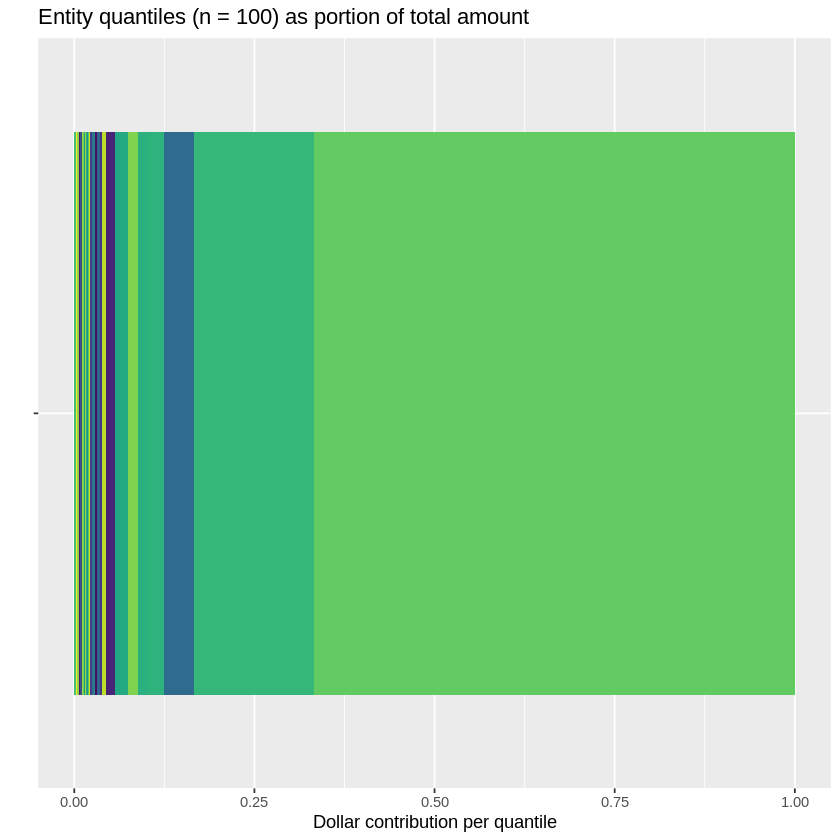

In [35]:
ggplot(data=per_quantile) +
  geom_bar(
    aes(y="", x=Amount, fill=quantile_colours),
    position="stack",
    stat="identity"
  ) + 
  ggtitle(sprintf("Entity quantiles (n = %d) as portion of total amount", num_quantiles)) +
  labs(x = "Dollar contribution per quantile", y="")

As you can see, the top 1% of entities account for more than 60% of the total amount paid.

### Greatest total payments

In [34]:
by_entity %>% arrange(desc(Amount)) %>%
  head(n=10) %>% 
  mutate(Amount = sprintf("%.1f B", Amount / 10^9))

entity,Amount
<chr>,<chr>
Bp Canada Energy Group Ulc,157.9 B
Total E&P Canada Ltd.,156.3 B
Cnooc Limited,108.1 B
Equinor Canada Ltd.,104.7 B
Bhp Canada Inc.,90.5 B
Rio Tinto Canada Inc,50.9 B
Chevron Canada Limited,45.4 B
Azucar Minerals Ltd.,36.1 B
Glencore Canada Corporation,30.5 B
